In [36]:
import sys
import json
import typing as tp
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
run_dir = outputs_dir / "2022-09-15/10-01-18"

In [101]:
def plot_labels_hist(labels: torch.Tensor, classes_num: int,
                     title: tp.Optional[str] = None, x_tick_interval: int = 10) -> None:
    unique_labels, labels_counts = labels.unique(return_counts=True)
    label_to_count = dict(zip(unique_labels.tolist(), labels_counts.tolist()))
    if classes_num is not None:
        label_to_count = {label: label_to_count.get(label, 0) for label in range(classes_num)}

    sns.barplot(x=list(label_to_count.keys()), y=list(label_to_count.values()))
    plt.xticks(range(0, classes_num, x_tick_interval), rotation=90)
    plt.xlabel("Class ID")
    if title is not None:
        plt.title(title)

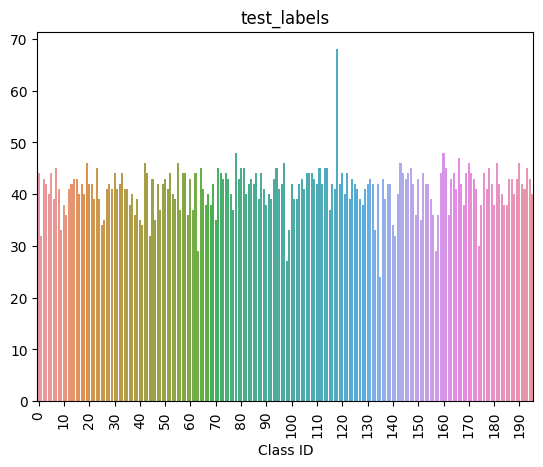

In [102]:
test_labels = torch.load(run_dir / "test_labels.pt")
classes_num = test_labels.unique().shape[0]
plot_labels_hist(test_labels, classes_num, "test_labels")

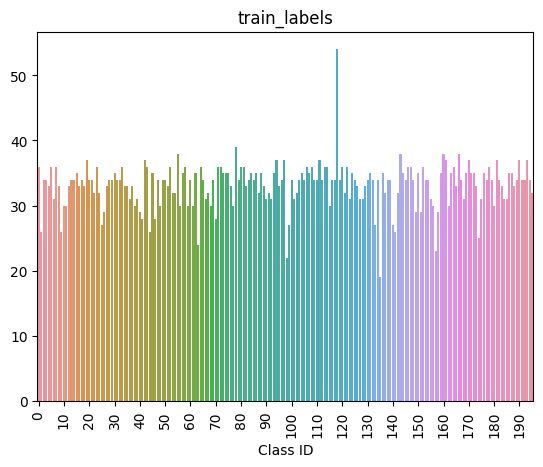

In [103]:
train_labels = torch.load(run_dir / "cache_labels.pt")
plot_labels_hist(train_labels, classes_num, "train_labels")

In [104]:
selected_cache_files = sorted(
    (run_dir / "selected_cache").iterdir(),
    key=lambda path: json.loads(path.with_suffix('').name)['topk']
)
len(selected_cache_files)

7

In [105]:
def plot_selected_cache(selected_cache_file: Path) -> None:
    cache_params = json.loads(selected_cache_file.with_suffix('').name)
    cache_params.pop('_target_')
    cache_labels = torch.load(selected_cache_file)
    plot_labels_hist(cache_labels, classes_num, str(cache_params))

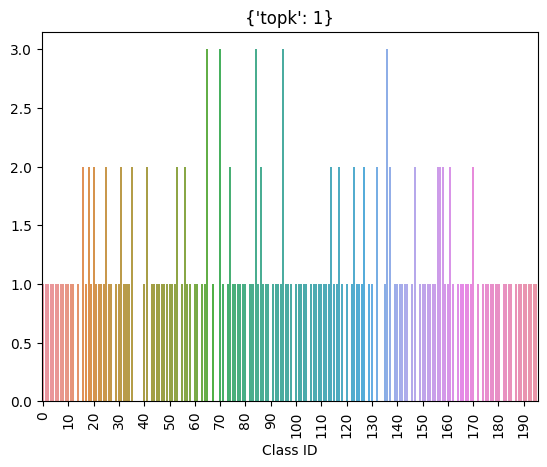

In [106]:
plot_selected_cache(selected_cache_files[0])

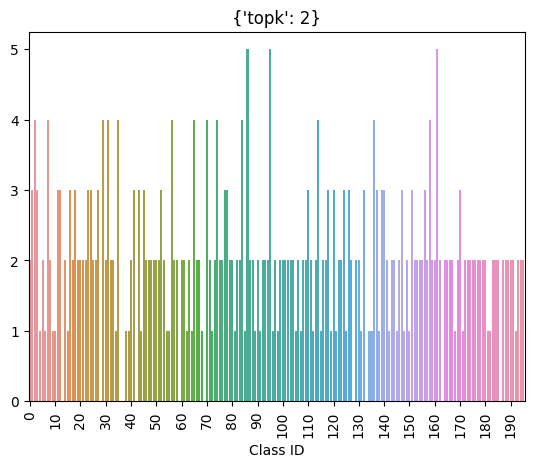

In [107]:
plot_selected_cache(selected_cache_files[1])

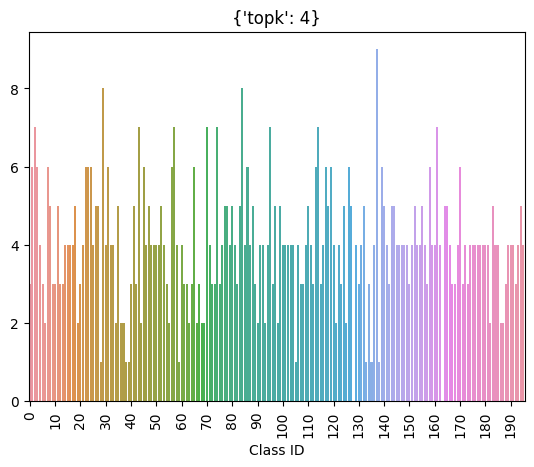

In [108]:
plot_selected_cache(selected_cache_files[2])

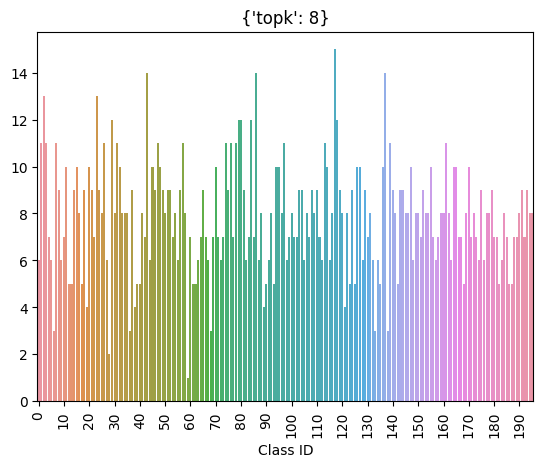

In [109]:
plot_selected_cache(selected_cache_files[3])

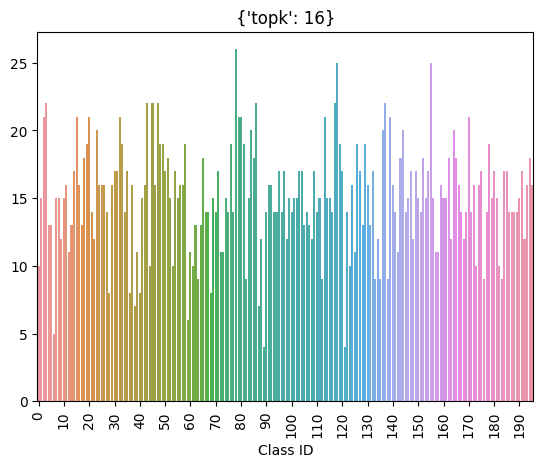

In [110]:
plot_selected_cache(selected_cache_files[4])

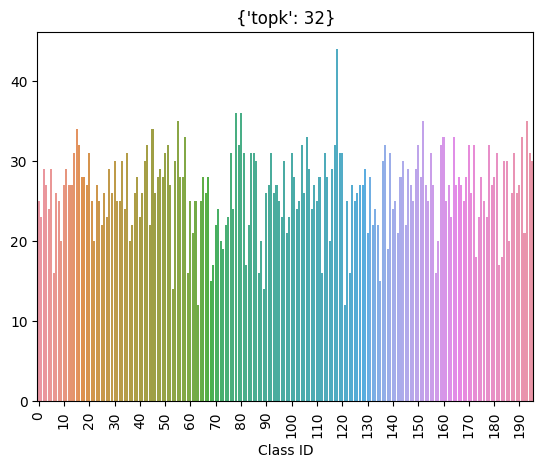

In [111]:
plot_selected_cache(selected_cache_files[5])

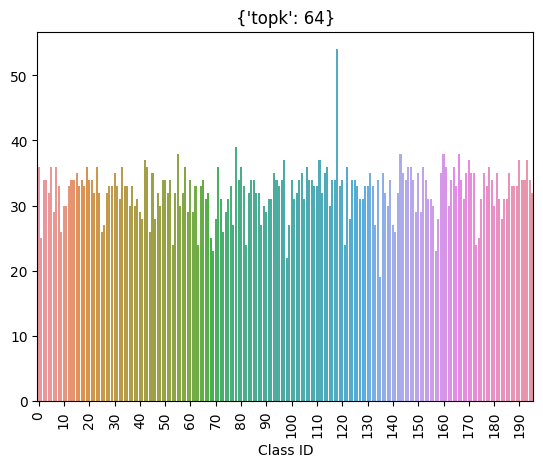

In [112]:
plot_selected_cache(selected_cache_files[6])